# RTBP Problem  : preliminary experiments

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-RTBP">
             Initial value problem: RTBP</a></li>

<li><a href="#Float64-Computations">
             Float64 Computations</a></li>

<li><a href="#Float128-Computations">
             Float128 Computations</a></li> 

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

</ul>  

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools
using Plots
using LinearAlgebra
using Dates,LaTeXStrings
using JLD2, FileIO
using BenchmarkTools
using IRKGaussLegendre

<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

4

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [3]:
using Hwloc
Hwloc.num_physical_cores()

8

<a href="#top">Back to the top</a>

## Initial value problem:  RTBP

In [4]:
setprecision(BigFloat, 108);
include("../ODEProblems/RTBP.jl")
include("../ODEProblems/InitialRTBP.jl")


t0=0.0
t1=parse(Float64,"17.0652165601579625588917206249")

u064,μ64 =InitialRTBP(Float64)
lpp=[μ64]
tspan64=(t0,2*t1)
prob64 = ODEProblem(f,u064,tspan64,[μ64]);

u0128,μ128=InitialRTBP(BigFloat)
tspan128=(BigFloat(t0),2*parse(BigFloat,"17.0652165601579625588917206249"))
prob128 = ODEProblem(f,u0128,tspan128,[μ128]);
(typeof(u064),typeof(μ64),typeof(tspan64),typeof(u0128),typeof(μ128),typeof(tspan128))

(Vector{Float64}, Float64, Tuple{Float64, Float64}, Vector{BigFloat}, BigFloat, Tuple{BigFloat, BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [5]:
setprecision(BigFloat, 256)
#sol =solve(prob128,Vern9(),save_everystep=false,abstol=1e-32,reltol=1e-32);
#@save "./Data/RTBP_test_sol.jld2" sol

@load "./Data/RTBP_test_sol.jld2" sol
test_sol = TestSolution(sol);
u0256,μ256 =InitialRTBP(BigFloat)

E0=RTBPEnergy(u0256,μ256)
(Float32(sol.t[end]),Float32(RTBPEnergy(sol.u[end],μ256)/E0.-1))

(17.065216f0, 3.193987f-31)

<a href="#top">Back to the top</a>

## Float64 Computations

### IRKGL16 

In [6]:
sol1 = solve(prob64,IRKGL16(), reltol=1e-12, abstol=1e-12, adaptive=true)
sol1.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  17472
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     2184
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          137
Number of rejected steps:                          25

In [7]:
norm(sol1.u[end]-sol1.u[1])

1.0091567080088421e-9

In [8]:
@btime solve(prob64,IRKGL16(), reltol=1e-12, abstol=1e-12, adaptive=true, save_everystep=false);

  1.689 ms (720 allocations: 222.58 KiB)


### IRKGL16-simd

In [9]:
sol2 = solve(prob64,IRKGL16(simd=true), reltol=1e-12, abstol=1e-12, adaptive=true)
sol2.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  19304
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     2413
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          137
Number of rejected steps:                          25

In [10]:
norm(sol2.u[end]-sol2.u[1])

8.112170178201425e-9

In [11]:
@btime solve(prob64,IRKGL16(simd=true), reltol=1e-12, abstol=1e-12, adaptive=true, save_everystep=false);

  725.690 μs (701 allocations: 255.88 KiB)


### Vern9 

In [12]:
sol9 =solve(prob64,Vern9(),abstol=1e-14,reltol=1e-14);
sol9.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  14354
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          884
Number of rejected steps:                          13

In [13]:
norm(sol9.u[end]-sol9.u[1])

7.62030613539845e-8

In [14]:
@btime solve(prob64,Vern9(),abstol=1e-14,reltol=1e-14, save_everystep=false);

  745.858 μs (56 allocations: 5.02 KiB)


### Some Plots

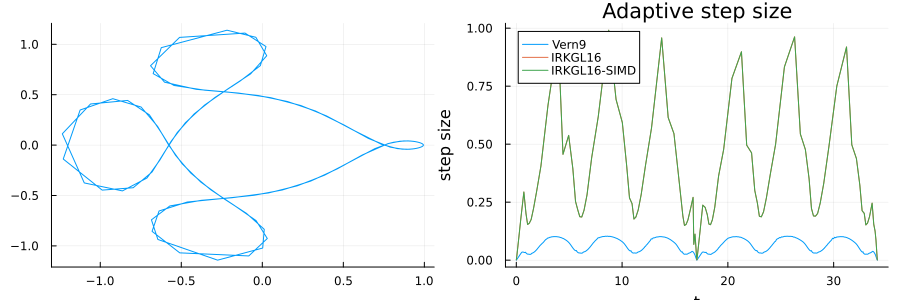

In [15]:
xx = [u[1] for u in sol1.u]
yy = [u[2] for u in sol1.u]
pl1=plot(xx,yy, label="")

steps1 =sol1.t[2:end]-sol1.t[1:end-1]
steps2 =sol2.t[2:end]-sol2.t[1:end-1]
steps9 =sol9.t[2:end]-sol9.t[1:end-1]
pl2=plot(xlabel="t", ylabel="step size",title="Adaptive step size")
plot!(pl2, sol9.t[2:end],steps9, label="Vern9")
plot!(pl2, sol1.t[2:end],steps1, label="IRKGL16")
plot!(pl2, sol2.t[2:end],steps2, label="IRKGL16-SIMD")

plot(pl1,pl2, layout=(1,2), size=(900,300))

<a href="#top">Back to the top</a>

## Float128 Computations

In [16]:
setprecision(BigFloat, 108);

### IRKGL16 

In [17]:
sol11 = solve(prob128, IRKGL16(), reltol=BigFloat(1e-20), abstol=BigFloat(1e-20), adaptive=true)
sol11.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  57288
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     7161
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          407
Number of rejected steps:                          38

In [18]:
norm(sol11.u[end]-sol11.u[1])

1.993990121519339647434820917478996e-11

In [19]:
@btime solve(prob128, IRKGL16(), reltol=BigFloat(1e-20), abstol=BigFloat(1e-20), adaptive=true, save_everystep=false);

  923.157 ms (12801417 allocations: 524.80 MiB)


### Vern9

In [20]:
sol19 =solve(prob128,Vern9(),abstol=1e-20,reltol=1e-20);
sol19.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  65442
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          4087
Number of rejected steps:                          3

In [21]:
norm(sol19.u[end]-sol19.u[1])

1.993963689085251532252436550089408e-11

In [22]:
@btime solve(prob128,Vern9(),abstol=1e-20,reltol=1e-20, save_everystep=false);

  1.739 s (20036630 allocations: 734.33 MiB)


<a href="#top">Back to the top</a>

## Error in energy

In [23]:
setprecision(BigFloat, 256)
u0256, μ256 =InitialRTBP(BigFloat)

E0=RTBPEnergy(u0256,μ256)

ΔE1 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol1.u)./E0.-1
ΔE2 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol2.u)./E0.-1
ΔE9 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol9.u)./E0.-1
ΔE11 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol11.u)./E0.-1
ΔE19 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol19.u)./E0.-1
(Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE1))), Float32(maximum(abs.(ΔE9))) ,Float32(maximum(abs.(ΔE11))) ,Float32(maximum(abs.(ΔE19))))

(1.0662631f-14, 1.0662631f-14, 4.2138805f-14, 8.3906445f-23, 7.621585f-22)

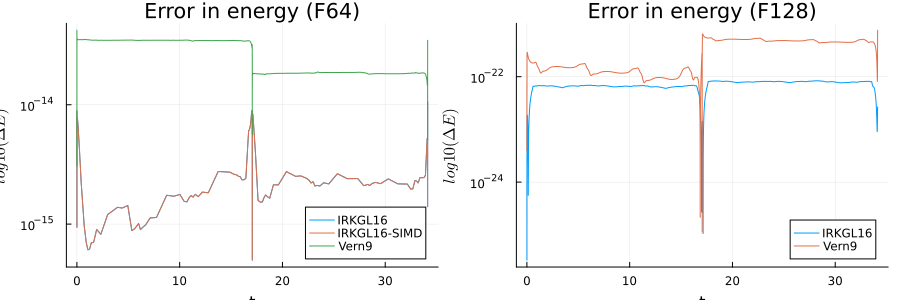

In [25]:
pl1=plot(title="Error in energy (F64)", xlabel="t", ylabel=L"log10(\Delta E)", legend=:bottomright)
plot!(pl1, sol1.t[2:end], abs.(ΔE1[2:end]), yscale=:log10, label="IRKGL16")
plot!(pl1, sol1.t[2:end], abs.(ΔE1[2:end]), yscale=:log10, label="IRKGL16-SIMD")
plot!(pl1, sol9.t[2:end], abs.(ΔE9[2:end]), yscale=:log10, label="Vern9")

pl2=plot(title="Error in energy (F128)", xlabel="t", ylabel=L"log10(\Delta E)", legend=:bottomright)
plot!(pl2, sol11.t[2:end], abs.(ΔE11[2:end]), yscale=:log10, label="IRKGL16")
plot!(pl2, sol19.t[2:end], abs.(ΔE19[2:end]), yscale=:log10, label="Vern9")

plot(pl1,pl2, layout=(1,2), size=(900,300))

<a href="#top">Back to the top</a>